In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import sys
import os

import scipy
import scipy.io
from scipy import stats

path_root = os.environ.get('DECIDENET_PATH')
path_code = os.path.join(path_root, 'code')
if path_code not in sys.path:
    sys.path.append(path_code)
from dn_utils.behavioral_models import load_behavioral_data

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 14})

In [2]:
path_jags = os.path.join(path_root, 'data/main_fmri_study/derivatives/jags')
path_parameter_estimates = os.path.join(path_jags, 'parameter_estimates')
path_vba = os.path.join(path_jags, 'vba')

# Load behavioral data
path_beh = os.path.join(path_root, 'data/main_fmri_study/sourcedata/behavioral')
beh, meta = load_behavioral_data(path_beh)
n_subjects, n_conditions, n_trials, _ = beh.shape

# Load parameter estimates
alpha_pdci = np.load(os.path.join(path_parameter_estimates, 'alpha_pdci_mle_3digits.npy'))

# Load posterior model probabilities for sequential model 
pmp = scipy.io.loadmat(
    os.path.join(path_vba, 'pmp_HLM_sequential_split.mat'), 
    squeeze_me=True)['pmp']

Shape of beh array: (32, 2, 110, 23)
Conditions [(0, 'rew'), (1, 'pun')]
Columns: [(0, 'block'), (1, 'block_bci'), (2, 'side'), (3, 'side_bci'), (4, 'magn_left'), (5, 'magn_right'), (6, 'response'), (7, 'rt'), (8, 'won_bool'), (9, 'won_magn'), (10, 'acc_after_trial'), (11, 'onset_iti'), (12, 'onset_iti_plan'), (13, 'onset_iti_glob'), (14, 'onset_dec'), (15, 'onset_dec_plan'), (16, 'onset_dec_glob'), (17, 'onset_isi'), (18, 'onset_isi_plan'), (19, 'onset_isi_glob'), (20, 'onset_out'), (21, 'onset_out_plan'), (22, 'onset_out_glob')]


## Behavioral performance

Behavioral performance is quantified as accuracy – frequency of correct choices during entire task condition. In reward-seeking condition correct choice leads to gain of points whereas in punishment-avoiding condition correcto choice leads to avoiding loss.

- **Test 1**: Is performance above chance level?
    - one-sample, one-sided t-test
    - $H_0$: Accuracy is at chance level.
    - $H_a$: Accuracy is greater than 50%.
- **Test 2**: Do task differ in performance?
    - two-sample, two-sided t-test
    - $H_0$: Accuracy for reward-seeking and punishment-avoiding condition is equal.
    - $H_a$: Accuracy differ between conditions.

In [3]:
# Mean accuracy for all subject and both task conditions
won_bool_mean = np.mean(beh[:, :, :, meta['dim4'].index('won_bool')], axis=2)

# Test 1
t_rew_test1, p_rew_test1 = stats.ttest_1samp(won_bool_mean[:, 0], popmean=0.5)
t_pun_test1, p_pun_test1 = stats.ttest_1samp(won_bool_mean[:, 1], popmean=0.5)
print(f'Test 1 (rew): t={t_rew_test1}, p={p_rew_test1 / 2}, accu={np.mean(won_bool_mean[:, 0])}')
print(f'Test 1 (pun): t={t_pun_test1}, p={p_pun_test1 / 2}, accu={np.mean(won_bool_mean[:, 1])}')

# Test 2
t_test2, p_test2 = stats.ttest_rel(won_bool_mean[:, 0], won_bool_mean[:, 1])
print(f'Test 2: t={t_test2}, p={p_test2}')

Test 1 (rew): t=12.995689038076979, p=2.1870092922595635e-14, accu=0.628125
Test 1 (pun): t=11.382848544925913, p=6.661166522570834e-13, accu=0.6213068181818182
Test 2: t=0.4991063442365201, p=0.621228100537964


### Reward magnitude infuence on choice

- **Test 3**: Do difference between reward magnitudes affects choice?
    - Pearson's correlation
    - variable 1: difference in reward magnitude for left and right side
    - variable 2: averaged (across subjects and conditions) probability of choosing right side

In `response_probability` array first column corresponds to all unique values of the difference in reward magnitude for left and right side and second column reflects proportion of right side choices for corresponding difference in reward magnitude.

In [4]:
magn_rl_diff = beh[:, :, :, meta['dim4'].index('magn_right')] \
             - beh[:, :, :, meta['dim4'].index('magn_left')] 
response = beh[:, :, :, meta['dim4'].index('response')]

diff_values = np.unique(magn_rl_diff)
response_probability = np.zeros((len(diff_values), 2))
response_probability[:, 0] = diff_values

for i, diff in enumerate(diff_values):
    diff_response = response[magn_rl_diff == diff]
    diff_response = diff_response[np.nonzero(diff_response)]
    response_probability[i, 1] = np.mean((diff_response + 1) / 2)
    
# Test 3
magn_rl_diff_stat = stats.pearsonr(response_probability[:, 0], response_probability[:, 1])
print('Test 3: r={:.3f}, p={}'.format(magn_rl_diff_stat[0], magn_rl_diff_stat[1]))

Test 3: r=0.948, p=5.646493095714412e-21


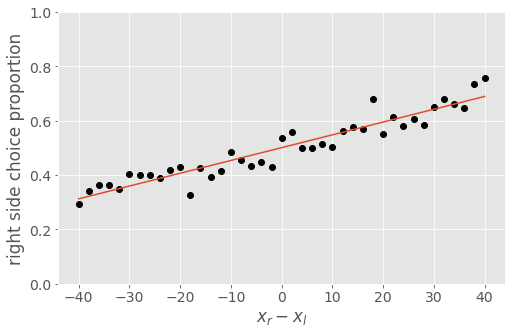

In [5]:
x = response_probability[:, 0]
y = response_probability[:, 1]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), facecolor='w')
ax.plot(x, y, 'ko')
ax.plot(x, np.poly1d(np.polyfit(x, y, 1))(x))

ax.set_xlabel('$x_r - x_l$')
ax.set_ylabel('right side choice proportion')
ax.set_ylim([0, 1])
plt.show()

### Probability matching behavior

Probability matching behavior results in frequent option switching after incorrect choice. Simple proxy for probability matching behavior is number of reversals – each reversal is single side switching. 

- **Test 4**: Do task differ in probability matching behavior?
    - two-sample, two-sided t-test
    - $H_0$: Mean number of reversals is equal for both conditions.
    - $H_a$: Mean number of differs between conditions.  
- **Test 5**: Is there a relationship between probability matching behavior and difference in learning rates for positive and negative prediciton error?
    - Pearson's correlation
    - variable 1: number of reversals
    - variable 2: difference in estimaated learning rates for positive and negative PEs $\alpha_{+}-\alpha_{-}$ (PDCI model)

In [6]:
# Number of reversals for each participant
def calculate_reversals(response):
    '''Calculate number of side switches in subject responses.'''
    return len(np.nonzero(np.diff(response[np.nonzero(response)]))[0])

reversals = np.zeros((n_subjects, n_conditions))
for i in range(n_subjects):
    for j in range(n_conditions):
        reversals[i, j] = calculate_reversals(beh[i, j, :, meta['dim4'].index('response')])
        
print(f'Mean number of reversals (rew): {np.mean(reversals[:, 0])}')
print(f'Mean number of reversals (pun): {np.mean(reversals[:, 1])}')
print(f'SD for reversals (rew): {np.std(reversals[:, 0])}')
print(f'SD for reversals (pun): {np.std(reversals[:, 1])}')
        
# Test 4
t_test4, p_test4 = stats.ttest_rel(reversals[:, 0], reversals[:, 1])
print(f'Test 4: t={t_test4}, p={p_test4}')

# Test 5
alpha_diff_reversal_stat = stats.pearsonr(
    alpha_pdci[:,0] - alpha_pdci[:,1], 
    np.mean(reversals, axis=1)
)
print('Test 5: r={:.3f}, p={}'.format(alpha_diff_reversal_stat[0], alpha_diff_reversal_stat[1]))

Mean number of reversals (rew): 30.40625
Mean number of reversals (pun): 30.25
SD for reversals (rew): 11.929111909002279
SD for reversals (pun): 11.979148550710939
Test 4: t=0.07794626295864657, p=0.9383717474097866
Test 5: r=-0.762, p=4.1039410032986164e-07


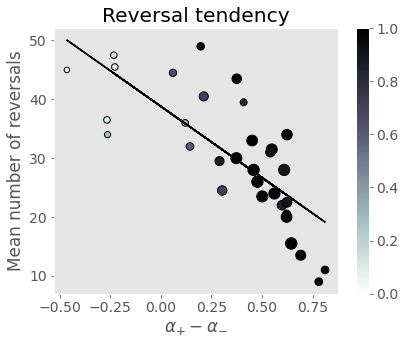

In [7]:
# Color indicates value alpha-, size indicates goodness-of-fit for the PDCI model
x = alpha_pdci[:,0] - alpha_pdci[:,1] 
y = np.mean(reversals, axis=1)
s = 100*(pmp[2, :] / np.max(pmp[2, :])) + 30
c = alpha_pdci[:, 0]

fig, ax = plt.subplots(figsize=(6, 5), facecolor='w')
sc = ax.scatter(
    x, y, s=s, c=c,
    cmap='bone_r', vmin=0, vmax=1,
    linewidth=1, edgecolor='k',
)

plt.colorbar(sc)
ax.plot(x, np.poly1d(np.polyfit(x, y, 1))(x), 'k')

ax.set_xlabel(r'$\alpha_{+} - \alpha_{-}$')
ax.set_ylabel('Mean number of reversals')
ax.set_axisbelow(True)
ax.set_title('Reversal tendency')
ax.grid()
plt.tight_layout()

In [8]:
reversals

array([[32., 40.],
       [42., 53.],
       [23., 24.],
       [30., 33.],
       [21., 31.],
       [30., 26.],
       [50., 48.],
       [24., 32.],
       [29., 15.],
       [ 8., 33.],
       [46., 35.],
       [41., 32.],
       [51., 38.],
       [33., 35.],
       [31., 17.],
       [38., 24.],
       [42., 45.],
       [45., 46.],
       [27., 32.],
       [29., 31.],
       [ 5., 13.],
       [54., 25.],
       [15., 12.],
       [29., 11.],
       [26., 23.],
       [16., 15.],
       [34., 32.],
       [13.,  9.],
       [35., 55.],
       [28., 40.],
       [20., 25.],
       [26., 38.]])